# QLearning

In [1]:
import math
import time

import numpy as np
import networkx as nx

from functools import reduce
import operator

import gym
import imageio

from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

In [2]:
def render_frames_as_gif(frames, filename):
    imageio.mimsave(filename, frames, duration = 1/35.)

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

# What is Q-Learning

The Q-Learning is an algorithm able to learn from trials. It's called like that as it uses a Q-Matrix which stores a mapping of State -> Action. It's similar to Markov Models. The mapping value is called a Q-Value. 

During the training stage, the algorithm will explore possibilities and stores a Q-value for every solution based on the outcome of the game. 

After the training, based on his current State, it will just pick the action with the highest reward.

The Q value is calculated using the <a href="https://en.wikipedia.org/wiki/Bellman_equation">Bellman's equation</a>.

As a result, the "brain" of this algorithm is a matrix of N-features dimensions and K states for every features. This will be presented with multiple examples below from the simplest one to the most complexe one). I won't do a complete explaination of it as there is plenty of content which explain it well. Just as example, we can say that this algorithm mimic the human's behavior on some cases like driving from point A to B.

<i>Let's imagine you don't have any GPS / directions and you want to go from your home to your work place. For few times, you may explore some paths. 

The first day, you try to take the first exit at the roundabout. After that you have a small road which directly goes to your company. You will spend 15 min to reach your goal.

The next day, you will take the second exit and reach an stright road but with red lights. You will spend 12 min this time.

The third day, you take the same road as it was faster but this time you need 20 min due to red lights... You will start to doubt about it.

The day after, you take the last exit and reach an highway with slightly more distance but you can reach your office in 10 min.

This is the phase of exploration. When you have explored enought, you decide to always take the shortest path which is the highway. You learnt it by doing trials.</i>

Now, let's do it first on this kind of example but bigger and then on more complicated problems.

# Shortest Path in a graph

To start with an easy exercice of a Q-Learner, let's implement an agent able to find the shortest path in a graph. To do so, I used a graph provided in Codingame for a puzzle. In this one, let's try to find the shortest path from Point 12 to Point 28.

In [3]:
initial_state = 12
goal = 28
nb_points = 49
gamma = 0.8
points_list = [(1, 0), (1, 2), (2, 3), (3, 4), (4, 5), (3, 6), (7, 3), (9, 5), (5, 8), (13, 0), 
               (14, 13), (15, 14), (16, 13),(17, 14), (18, 15), (19, 15), (19, 20), (19, 18), 
               (18, 20), (22, 20), (0, 23), (23, 14), (23, 16), (21, 20), (24, 21), (24, 17), 
               (28, 27), (27, 29), (27, 26), (26, 25), (25, 21), (21, 30), (30, 34), (31, 35), 
               (32, 36), (38, 33), (33, 37), (33, 32), (32, 31), (31, 30), (33, 39), (9, 40), 
               (39, 40), (41, 2), (39, 42), (42, 43), (43, 10), (34, 46), (35, 45), (37, 40), 
               (41, 46), (44, 45), (44, 40), (7, 41), (5, 10), (47, 12), (11, 47), (10, 47), 
               (43, 47), (46, 48), (45, 48), (48, 7)] 

<img src = "graphe2.png" />

In [4]:
# G=nx.Graph()
# G.add_edges_from(points_list)
# pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G,pos)
# nx.draw_networkx_edges(G,pos)
# nx.draw_networkx_labels(G,pos)
# plt.show()

Now let's create the reward matrix. This one will contain :
- -1 if there is no link
- 0 if there is a link
- 100 if the link goes to the end of the graph

This is not required in general. In that case we do it to have possible actions and rewards but any other things may be used as we will see with gym.

In [5]:
R = -1 * np.matrix(np.ones(shape=(nb_points, nb_points)))

for point in points_list:
    if point[1] == goal:
        R[point] = 100
    else:
        R[point] = 0

    if point[0] == goal:
        R[point[::-1]] = 100
    else:
        R[point[::-1]]= 0

R[goal,goal]= 100

R

matrix([[-1.,  0., -1., ..., -1., -1., -1.],
        [ 0., -1.,  0., ..., -1., -1., -1.],
        [-1.,  0., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1.,  0.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ...,  0., -1., -1.]])

## Training

Now we can do the training. To do so, we have to create a Q matrix of (n_states, n_actions). In that case, we have 49 states and 49 actions (every action lead to another state, but some actions won't be available in this specific case). 
Now to fill this matrix, we will use the <a href="https://en.wikipedia.org/wiki/Bellman_equation">Bellman equation</a>.

The training will stop when the score will converge and be in a smaller range than 5.

In [6]:
def available_actions(state):
    current_state_row = R[state]
    av_act = np.where(current_state_row >= 0)[1]
    return av_act

def sample_next_action(available_actions_range):
    next_action = np.random.choice(available_act, 1)[0]
    return next_action

def update(current_state, action, gamma):
    max_value = np.max(Q[action, :])
  
    Q[current_state, action] = R[current_state, action] + gamma * max_value
  
    if (np.max(Q) > 0):
        return(np.sum(Q/np.max(Q)*100))
    else:
        return (0)

Trained Q matrix:
[[ 0.         10.57123048  0.         ...  0.          0.
   0.        ]
 [13.41085335  0.         13.2140381  ...  0.          0.
   0.        ]
 [ 0.         10.72035992  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
  16.76356668]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ... 20.95445835  0.
   0.        ]]
Execution time : 0.330


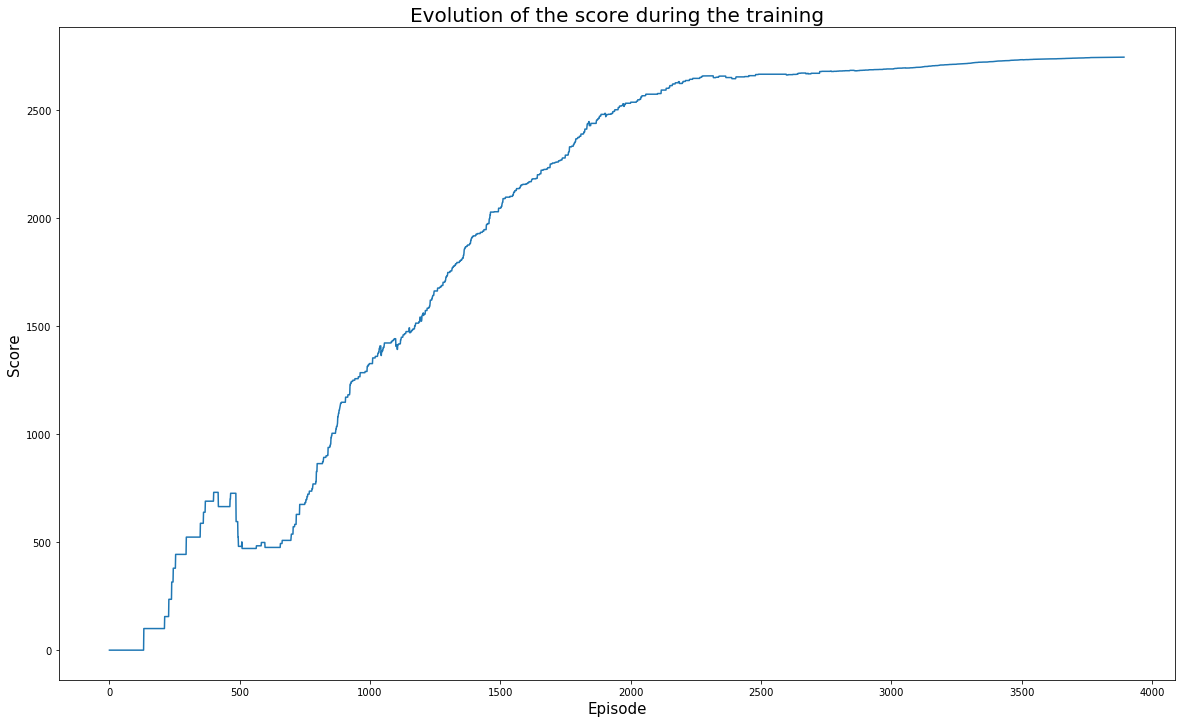

In [7]:
Q = np.matrix(np.zeros([nb_points, nb_points]))

start = time.time()

scores = []
while True:
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act)
    score = update(current_state,action,gamma)
    scores.append(score)
    
    if len(scores) > 200:
        if max(scores[-200:]) - min(scores[-200:]) < 5:
            break
    
end = time.time()
    
print("Trained Q matrix:")
print(Q/np.max(Q)*100)
print("Execution time : {:.3f}".format(end-start))

plt.figure(figsize=(20,12))
plt.plot(scores)
plt.title("Evolution of the score during the training", fontsize=20)
plt.ylabel("Score", fontsize=15)
plt.xlabel("Episode", fontsize=15)
plt.show()

Depending on the random, it takes around 2500 simulation to converge. After that, we can use it to find the shortest path.

## Testing

As mentionned previously, for the test, we just have to take for every step the action which lead to the highest Q-value.

In [8]:
current_state = initial_state
steps = [current_state]

while current_state != goal:

    next_step_index = np.where(Q[current_state,] == np.max(Q[current_state,]))[1]
    
    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size = 1))
    else:
        next_step_index = int(next_step_index)
    
    steps.append(next_step_index)
    current_state = next_step_index

print("Most efficient path:")
print(steps)

Most efficient path:
[12, 47, 43, 42, 39, 33, 32, 31, 30, 21, 25, 26, 27, 28]


We can see that the path is the shortest. This algorithm is not the fastest one if we compare it to other known algorithms like Dijkstra but we will see just after that it can do a lot better than this small example.

# Gym : MountainCar

## Presentation

In this environment, we have to climb a mountain with a vehicule. The problem is that the engine is not powerfull enought to climb it directly. We need to increase the momentum by balancing the car but this solution won't be provided to the algorithm. It has to figure it our by himself. 

I used this environment first because there is only 2 observations with limits and the output are finite values. The explaination of this environement is available <a href="https://github.com/openai/gym/wiki/MountainCar-v0">here</a>. The only difficulty is on the reward, we have it only if you reached the top so the algorithm will start randomly and may take time to at least succeed once and start to have the correct behavior.

Prior to start, let's look at a random agent playing.

## Random agent

In [9]:
env = gym.make('MountainCar-v0')

observation = env.reset()
frames = []
for t in range(200):
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
env.close()

# render_frames_as_gif(frames, "gym_gifs/random_mountain_car.gif")

<img src="gym_gifs/random_mountain_car.gif"/>

## Training

Now let's do the training. Let's first have a quick look at the environment

In [10]:
score, step = 0, 0
obs = env.reset()
print("Example of observations :", obs)
print("Example of output :", env.action_space.sample() )
print("Minimum of observation state :", env.observation_space.low)
print("Maximum of observation state :", env.observation_space.high)
print("Output space :", env.action_space.n)

Example of observations : [-0.42245627  0.        ]
Example of output : 0
Minimum of observation state : [-1.2  -0.07]
Maximum of observation state : [0.6  0.07]
Output space : 3


This project is quite simple to train as we have only 2 features. We will just discretize them and the size of the state space will be quite small

In [11]:
Sample_1 = np.around(np.arange(env.observation_space.low[0], env.observation_space.high[0], 0.1), 1)
Sample_2 = np.around(np.arange(env.observation_space.low[1], env.observation_space.high[1], 0.01), 2)

print("Size of the State space : {} x {} = {}".format(len(Sample_1), len(Sample_2), len(Sample_1) * len(Sample_2)))

Size of the State space : 19 x 15 = 285


So here we have only 285 possibilities of states (based on our current discretization). This search space being small, the training won't require a lot of test to find the proper policy.

In [12]:
iter_max = 2500

initial_lr = 1.0
min_lr = 0.03
gamma = 1.0
t_max = 10000
eps = 0.02

In this simple example, we will explore in fully random pick in 2% of states. For the rest, we will pass all Q-values for this state to a sigmoid function to have a random probablity of all actions. The biggest value the Q value will be, the more it may be picked. Nevertheless, the random will still be used to pick an action.

An other point to see is that the Bellman equation slightly changed. This equation is the one from an extension of the Q-Learning called SARSA for State-Action-Reward-State-Action. It uses the expected reward a the next step to update the Q-value and not only the reward.

In [13]:
def softmax(X):
    logits_exp = np.exp(X)
    probs = logits_exp / np.sum(logits_exp)
    return probs

def obs_to_state(obs):
    rounded_obs_1 = np.around(obs[0], 1)
    rounded_obs_2 = np.around(obs[1], 2)
    state_act_1 = np.where(Sample_1 == rounded_obs_1)[0][0]
    state_act_2 = np.where(Sample_2 == rounded_obs_2)[0][0]
    return (state_act_1, state_act_2)

In [14]:
Q = np.zeros(shape=(len(Sample_1), len(Sample_2), env.action_space.n), dtype=np.float32)
scores = []
for i in range(iter_max):
    obs = env.reset()
    total_reward = 0
    ## eta: learning rate is decreased at each step
    eta = max(min_lr, initial_lr * (0.85 ** (i//100)))
    for j in range(t_max):
        state = obs_to_state(obs)
        if np.random.uniform(0, 1) < eps:
            action = np.random.choice(env.action_space.n)
        else:
            probs = softmax(Q[state])
            action = np.random.choice(env.action_space.n, p=probs)
        obs, reward, done, _ = env.step(action)
        total_reward += reward

        new_state = obs_to_state(obs)
        Q[state][action] = Q[state][action] + eta * (reward + gamma *  np.max(Q[new_state]) - Q[state][action])
        if done:
            break
    
    scores.append(total_reward)

C:\python36\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\python36\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


We have a reward of -1 every step. LIf we failed to reach the top, we have -200. If we reached the top faster, we still have a negative reward but higher. Now we know that, let's look at the reward. 

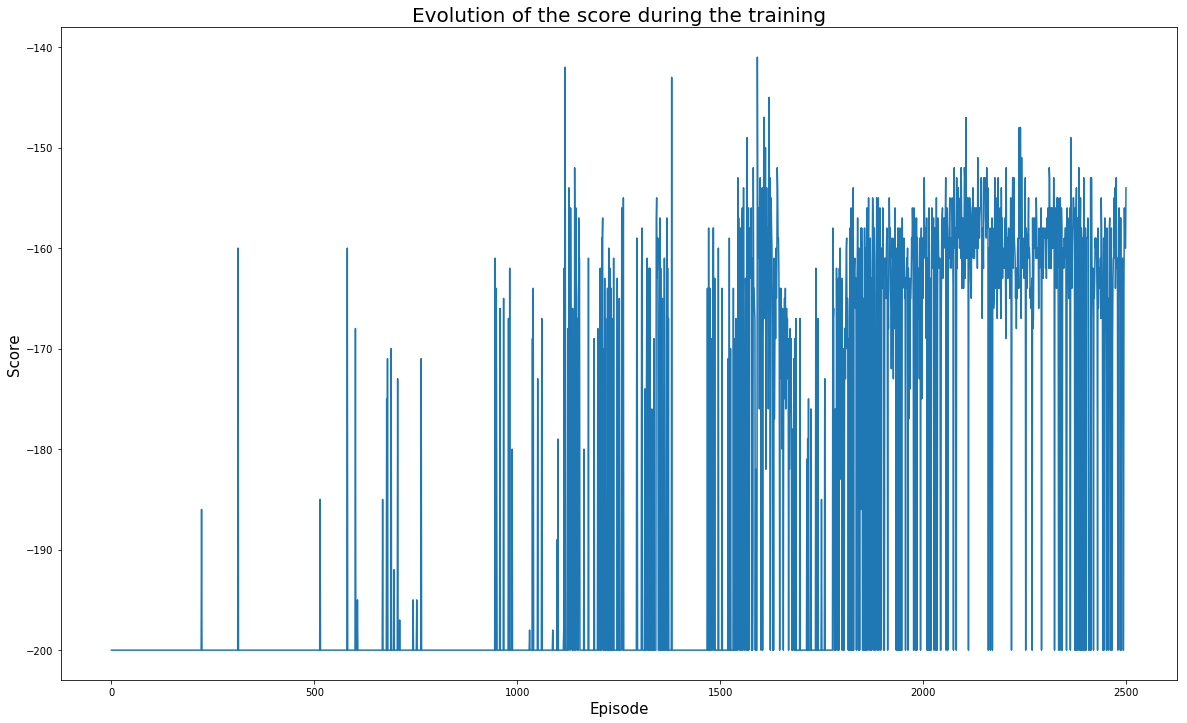

In [15]:
plt.figure(figsize=(20,12))
plt.plot(scores)
plt.title("Evolution of the score during the training", fontsize=20)
plt.ylabel("Score", fontsize=15)
plt.xlabel("Episode", fontsize=15)
plt.show()

Compare to the previous environment, the result has more noise. It required several hundredhth of trial before to understand how to win. With 1000 iterations, we may still fail because will still pick action randomly or because the training is not perfect yet. The more training we do, the better will be algorithm as the probability to pick an action will be more and more the correct one.

## Testing

In [16]:
env = gym.make("MountainCar-v0")

frames = []
obs = env.reset()
while True:
    frames.append(env.render(mode = 'rgb_array'))
    state = obs_to_state(obs)
    action = np.argmax(Q[state])
    obs, reward, done, _ = env.step(action)
    if done:
        break

env.close()

# render_frames_as_gif(frames, "gym_gifs/trained_mountain_car.gif")

<img src="gym_gifs/trained_mountain_car.gif"/>

# Gym : CartPole

## Presentation

The 3rd example is a bit more complex. The idea here is to maintain a pole at the vertical by moving left or right a cart. In this environment, we have reward at every steps (compare to the previous example where we have rewards only if we reached the top). The drawback here is that our environment has 2 observation which are continuous and infinite (cart speed and pole angular velocity) and we have 4 observations in total. This will lead to an higher state space. But first, let's try a random agent.

In [17]:
env = gym.make('CartPole-v0')

observation = env.reset()
frames = []
for t in range(200):
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
env.close()

# render_frames_as_gif(frames, "gym_gifs/random_cartpole.gif")

WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


<img src="gym_gifs/random_cartpole.gif"/>

## Training

Now let's do the training. As usual, let's first have a quick look at the environment.

In [18]:
score, step = 0, 0
obs = env.reset()
print(obs)
print(env.action_space.sample() )
print(env.observation_space.low)
print(env.observation_space.high)
print(env.action_space.n)

[-0.01648319  0.02870944  0.00409404  0.02072013]
1
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
2


As we have continuous states and 2 infinites ones, we have to take decisions. In my case, I reduced the 2 infinites states by a values clipped to :
- +/- 0,5 for the X_dot 
- +/- 0,872 for the Theta_dot 

After I discretize the state in a reasonable number of bins.

In [19]:
Sample_X = np.around(np.arange(env.observation_space.low[0], env.observation_space.high[0], 0.4), 1)
Sample_X_dot = np.around(np.arange(-0.5, 0.5, 0.05), 2)
Sample_theta = np.around(np.arange(env.observation_space.low[2], env.observation_space.high[2], 0.03), 2)
Sample_theta_dot = np.around(np.arange(-math.radians(50), math.radians(50), 0.05), 2)

Q = np.zeros(shape=(len(Sample_X)+1, len(Sample_X_dot)+1, len(Sample_theta)+1, len(Sample_theta_dot)+1, env.action_space.n), dtype=np.float32)

print("Size of the State space :", Q.shape)
print("Number of States :", reduce(operator.mul, Q.shape, 1))

Size of the State space : (26, 21, 29, 36, 2)
Number of States : 1140048


Our space state is now a lot bigger... close to 1 millions states. By luck, some of them won't be explored as they are very rare. We can see that our model have 43848 possibilities of actions and the training will try to figure out the actions to use in all of this conditions.

Compare to the previous example, we will now drive the exploration factor and learning rate to decrease from time. This will replace the sigmoid used previously. We will either pick a random value, or pick the one with the best Q-Value.

In [20]:
def obs_to_state(obs):
    state_X = 0 # int(np.digitize(obs[0], Sample_X))
    state_X_dot = int(np.digitize(obs[1], Sample_X_dot))
    state_theta = int(np.digitize(obs[2], Sample_theta))
    state_theta_dot = int(np.digitize(obs[3], Sample_theta_dot))
    return (state_X, state_X_dot, state_theta, state_theta_dot)

iter_max = 10000

initial_lr = 1.0 # Learning rate
min_lr = 0.3
gamma = 1.0
t_max = 10000

min_epsilon = 0.1
ada_divisor  = 25

Q = np.zeros(shape=(len(Sample_X)+1, len(Sample_X_dot)+1, len(Sample_theta)+1, len(Sample_theta_dot)+1, env.action_space.n), dtype=np.float32)
scores = []
for i in range(iter_max):
    obs = env.reset()
    new_state = obs_to_state(obs)
    total_reward = 0
    eta = max(min_lr, min(1.0, 1.0 - math.log10((i + 1) / ada_divisor) ))
    eps = max(min_epsilon, min(1, 1.0 - math.log10((i + 1) / ada_divisor) ))
    for j in range(t_max):
        current_state = new_state
        if np.random.random() < eps:
            action = np.random.choice(env.action_space.n)
        else:
            action = np.argmax(Q[current_state])
        obs, reward, done, _ = env.step(action)
        total_reward += reward

        new_state = obs_to_state(obs)
        Q[current_state][action] += eta * (reward + gamma * np.max(Q[new_state]) - Q[current_state][action])
        if done:
            break

    scores.append(total_reward)
    if i > 249 and i % 250 == 0 :
        print("Iteration {} - Average score on the 250 latest = {}".format(i, sum(scores[-250:]) / 250))

Iteration 250 - Average score on the 250 latest = 16.476
Iteration 500 - Average score on the 250 latest = 15.952
Iteration 750 - Average score on the 250 latest = 18.1
Iteration 1000 - Average score on the 250 latest = 18.064
Iteration 1250 - Average score on the 250 latest = 21.944
Iteration 1500 - Average score on the 250 latest = 24.772
Iteration 1750 - Average score on the 250 latest = 43.104
Iteration 2000 - Average score on the 250 latest = 60.176
Iteration 2250 - Average score on the 250 latest = 86.732
Iteration 2500 - Average score on the 250 latest = 85.996
Iteration 2750 - Average score on the 250 latest = 91.924
Iteration 3000 - Average score on the 250 latest = 112.82
Iteration 3250 - Average score on the 250 latest = 127.468
Iteration 3500 - Average score on the 250 latest = 135.004
Iteration 3750 - Average score on the 250 latest = 127.42
Iteration 4000 - Average score on the 250 latest = 151.784
Iteration 4250 - Average score on the 250 latest = 155.952
Iteration 4500 

Like we did previously, we can look at scores over episodes.

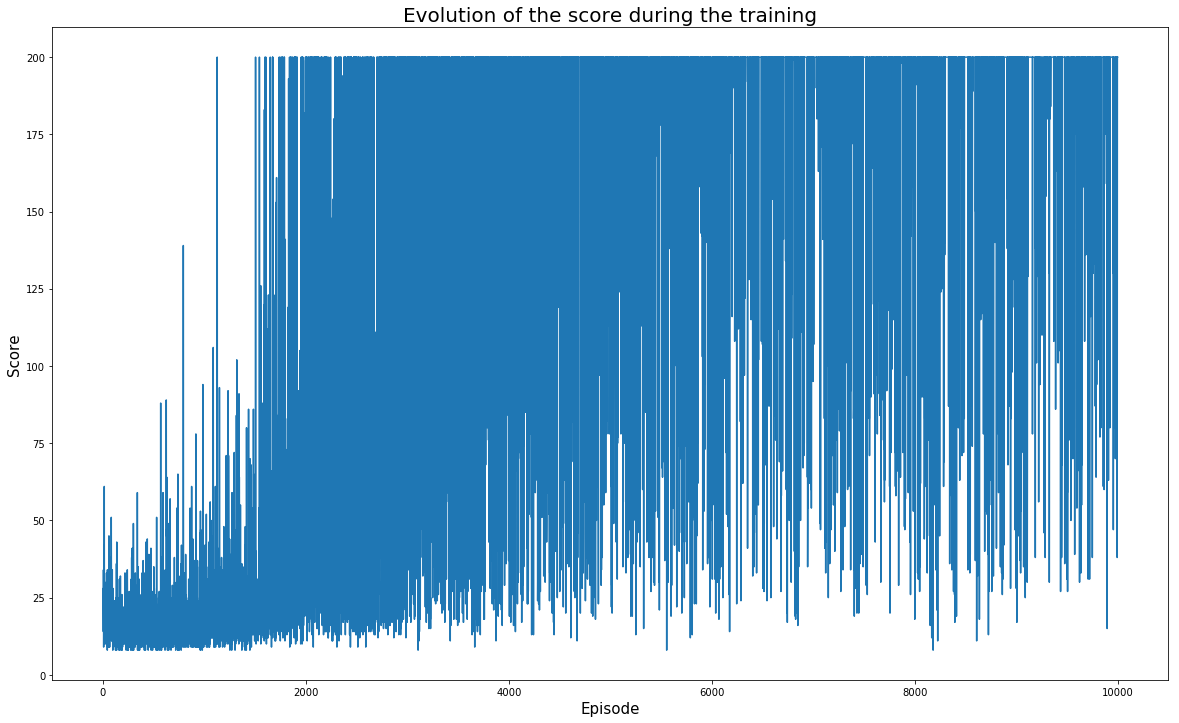

In [21]:
plt.figure(figsize=(20,12))
plt.plot(scores)
plt.title("Evolution of the score during the training", fontsize=20)
plt.ylabel("Score", fontsize=15)
plt.xlabel("Episode", fontsize=15)
plt.show()

We can see a trend but the result is noisy still due to random. We can now test it.

## Testing

As we did previously, we can do the same code for this environment

In [22]:
env = gym.make("CartPole-v0")

frames = []
obs = env.reset()
while True:
    frames.append(env.render(mode = 'rgb_array'))
    state = obs_to_state(obs)
    action = np.argmax(Q[state])
    obs, reward, done, _ = env.step(action)
    if done:
        break

env.close()

# render_frames_as_gif(frames, "gym_gifs/train_cartpole.gif")

<img src="gym_gifs/train_cartpole.gif"/>

We can see that it worked well. It's not perfect yet, to do so, we may need to increase the number of states to have more possibilities (for example for values close to 0)

# Gym : Pendulum

## Presentation

This 3rd environment is different. Now we have 2 finite number which are the sine and cosine of the pole angle and the 3rd one is also continuous but infinite. We already know how to manage this kind of states but now the reward is also continuous. The main difference with previous models is the action, it's a continuous one. As a result, we will discretize it and we will map the index of the action to the value. 

Prior to do the training, let's again check the outcome of a random agent.

In [23]:
env = gym.make("Pendulum-v0")

observation = env.reset()
frames = []
for t in range(200):
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
env.close()

# render_frames_as_gif(frames, "gym_gifs/random_pendulum.gif")

<img src="gym_gifs/random_pendulum.gif"/>

# Training

Let's look at the environment.

In [24]:
score, step = 0, 0
obs = env.reset()
print(obs)
print(env.action_space.sample() )
print(env.observation_space.low)
print(env.observation_space.high)
print(env.action_space)

[ 0.77528758  0.6316084  -0.31375755]
[-0.21142463]
[-1. -1. -8.]
[1. 1. 8.]
Box(1,)


Now let's discretize the values. We can go faster as it is exactly the same code as previously except ranges and bins

In [25]:
Sample_cos_theta = np.around(np.arange(env.observation_space.low[0], env.observation_space.high[0], 0.1), 1)[1:]
Sample_sin_theta = Sample_cos_theta
Sample_theta_dot = np.around(np.arange(env.observation_space.low[2], env.observation_space.high[2], 1), 0)[1:]
Sample_out = np.around(np.arange(-2, 2.2, 0.2), 1)

bins_angle = len(Sample_cos_theta) + 1
bins_angle_dot = len(Sample_theta_dot) + 1
bins_out = len(Sample_out)

In [26]:
iter_max = 10000

initial_lr = 1.0 # Learning rate
min_lr = 0.3
gamma = 1.0
t_max = 10000

min_epsilon = 0.1
ada_divisor  = 25

In [27]:
def obs_to_state(obs):
    state_cos_theta = int(np.digitize(obs[0], Sample_cos_theta))
    state_sin_theta = int(np.digitize(obs[1], Sample_sin_theta))
    state_theta_dot = int(np.digitize(obs[2], Sample_theta_dot))
    return (state_cos_theta, state_sin_theta, state_theta_dot)

In [28]:
Q = np.zeros(shape=(bins_angle, bins_angle, bins_angle_dot, bins_out), dtype=np.float32)
scores = []
for i in range(iter_max):
    obs = env.reset()
    new_state = obs_to_state(obs)
    total_reward = 0
    eta = max(min_lr, min(1.0, 1.0 - math.log10((i + 1) / ada_divisor) ))
    eps = max(min_epsilon, min(1, 1.0 - math.log10((i + 1) / ada_divisor) ))
    for j in range(t_max):
        current_state = new_state
        if np.random.random() < eps:
            action_idx = np.random.randint(len(Sample_out))
        else:
            action_idx = np.argmax(Q[current_state])
        
        action = Sample_out[action_idx]  # map index to action value
        obs, reward, done, _ = env.step([action])
        total_reward += reward

        new_state = obs_to_state(obs)
        Q[current_state][action_idx] += eta * (reward + gamma * np.max(Q[new_state]) - Q[current_state][action_idx])
        if done:
            break

    scores.append(total_reward)
    if i > 249 and i % 250 == 0 :
        print("Iteration {} - Average score on the 250 latest = {}".format(i, sum(scores[-250:]) / 250))

Iteration 250 - Average score on the 250 latest = -1209.6464361138474
Iteration 500 - Average score on the 250 latest = -1212.570555764416
Iteration 750 - Average score on the 250 latest = -1184.0714911747423
Iteration 1000 - Average score on the 250 latest = -1148.7972695120905
Iteration 1250 - Average score on the 250 latest = -1135.6029012281142
Iteration 1500 - Average score on the 250 latest = -1071.0954056540033
Iteration 1750 - Average score on the 250 latest = -1070.6157378420157
Iteration 2000 - Average score on the 250 latest = -1034.9575431691674
Iteration 2250 - Average score on the 250 latest = -994.8311363499756
Iteration 2500 - Average score on the 250 latest = -983.990401390912
Iteration 2750 - Average score on the 250 latest = -921.331778359511
Iteration 3000 - Average score on the 250 latest = -951.5286335955468
Iteration 3250 - Average score on the 250 latest = -893.5653315505654
Iteration 3500 - Average score on the 250 latest = -848.7965130570647
Iteration 3750 - A

We can see that on average the score increase (or is closer to 0, as it is the best possible value). As usual let's test it.

# Testing

Hera again, we can use the same code except that our algo with output the index of the output value and not directly the value. We should use the mapping use for the training.

In [29]:
env = gym.make("Pendulum-v0")

frames = []
obs = env.reset()
while True:
    frames.append(env.render(mode = 'rgb_array'))
    state = obs_to_state(obs)
    action_idx = np.argmax(Q[state])
    obs, reward, done, _ = env.step([Sample_out[action_idx]])  # conversion index to value
    if done:
        break

env.close()

# render_frames_as_gif(frames, "gym_gifs/trained_pendulum.gif")

<img src="gym_gifs/trained_pendulum.gif"/>

# Gym : Acrobot

## Presentation

The final environment is a lot more difficult. We have a double-pendulum and we can control the torque of the first pendulum and the objective is to place the 2nd pendulum above a certain height. As usual, let's explore a random agent.

In [30]:
env = gym.make("Acrobot-v1")

observation = env.reset()
frames = []
for t in range(200):
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
env.close()

# render_frames_as_gif(frames, "gym_gifs/random_acrobot.gif")

<img src="gym_gifs/random_acrobot.gif"/>

# Training

In term of features, we now have 6 parameters continuous but finite. In addition, we have reward only if we reached the top... this seems like the car but with more observations so let's start as usual

In [31]:
obs = env.reset()
print(obs)
print(env.action_space.sample() )
print(env.observation_space.low)
print(env.observation_space.high)
print(env.action_space.n)

[ 0.99797659 -0.0635824   0.9998353  -0.01814871 -0.01002725 -0.08765161]
0
[ -1.        -1.        -1.        -1.       -12.566371 -28.274334]
[ 1.        1.        1.        1.       12.566371 28.274334]
3


So we know that we have to discretize them for the Q-Matrix

In [32]:
Sample_1 = np.around(np.linspace(-math.pi, math.pi, 20), 1)
Sample_2 = Sample_1
Sample_3 = Sample_1
Sample_4 = Sample_1
Sample_5 = np.around(np.linspace(env.observation_space.low[4], env.observation_space.high[4], 15), 2)
Sample_6 = np.around(np.linspace(env.observation_space.low[5], env.observation_space.high[5], 15), 2)

Now let's create the Q-Matrix and check his state-action space :

In [33]:
Q = np.zeros(shape=(len(Sample_1)+1, 
                    len(Sample_2)+1, 
                    len(Sample_3)+1,
                    len(Sample_4)+1,
                    len(Sample_5)+1,
                    len(Sample_6)+1,
                    env.action_space.n), dtype=np.float32)

print(Q.shape)
print("Number of States :", reduce(operator.mul, Q.shape, 1))

(21, 21, 21, 21, 16, 16, 3)
Number of States : 149361408


Hum ... 149 millions of states-actions possible. It's definitively too much. You can try to train it but even if we let it run for hours it won't work. First of all due to the number of parameters and also because the reward appears only if you succeed to place the pole above the limit. With random action, it's gonna be nearly impossible to explore all the possibilities and learn it. A solution in such case would be to reduce dimensions. We can think about reducing cosine and sine to angle the feature :

- features 1 and 2 are sine and cosine of the 1st pole
- features 3 and 4 are sine and cosine of the 2nd pole

This may be reduced to only angle but we will still have around:

36 x 36 x 16 x 16 possibilites (if we take 1 state per 10 degrees). This is still too much for this puzzle. In addition 10 degree in not accurate enough...

The solution in that case would be to reduce those dimensions with neural networks in a model called Deep Q-network or DQN but this will be for a future Notebook (I'm learning at the same time :s)

# Conclusion

In this long Notebook we dig a bit into Q-Learning. We discussed about how to prepare the observations, how to train the model but we realize also that it's limited in State-Action space. We also saw few solutions to tweak the model (sigmoid of output and pick based on probabilities, fully stable random exploration, decreasing exploration over time) We need to use other algorithms for most difficult problems but this will be for later.